# Multiclass classification prediction for popularity of a song

Import all the packages

In [509]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import linear, relu

%matplotlib widget
import matplotlib.pyplot as plt

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

## Import data

In [510]:
df = pd.read_csv("spotify_data/spotify_songs.csv")

df = df.drop(['track_id','track_name','track_album_id','track_album_name','playlist_id','playlist_name'], axis= 1 ) # These features are not needed for prediction
df.head()

,track_artist,track_popularity,track_album_release_date,playlist_genre,playlist_subgenre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,Ed Sheeran,66,2019-06-14,pop,dance pop,0.748,0.916,6,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754
1,Maroon 5,67,2019-12-13,pop,dance pop,0.726,0.815,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600
2,Zara Larsson,70,2019-07-05,pop,dance pop,0.675,0.931,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616
3,The Chainsmokers,60,2019-07-19,pop,dance pop,0.718,0.930,7,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093
4,Lewis Capaldi,69,2019-03-05,pop,dance pop,0.650,0.833,1,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052


In [511]:
df.shape

(32833, 17)

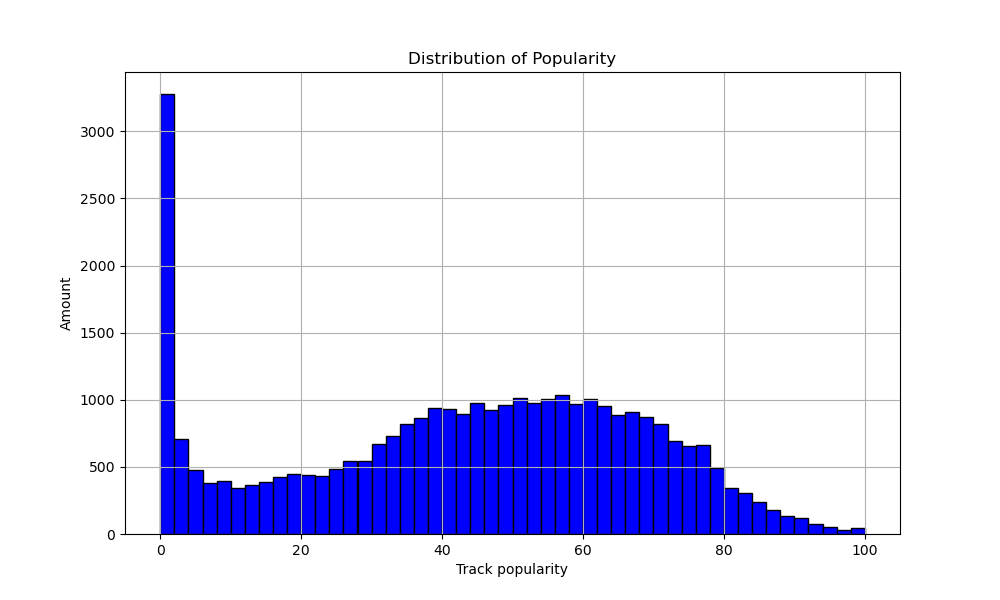

In [512]:
# Plot the distribution of track_popularity
plt.figure(figsize=(10,6))
plt.hist(df['track_popularity'], bins=50, color='blue', edgecolor='black')
plt.title('Distribution of Popularity')
plt.xlabel('Track popularity')
plt.ylabel('Amount')
plt.grid(True)
plt.show()

### Checking for null or NaN values

In [513]:
missing_popularity = df['track_popularity'].isnull().any()

missing_popularity

False

## Drop the songs with popularity zero

In [514]:
df = df[df['track_popularity'] != 0]

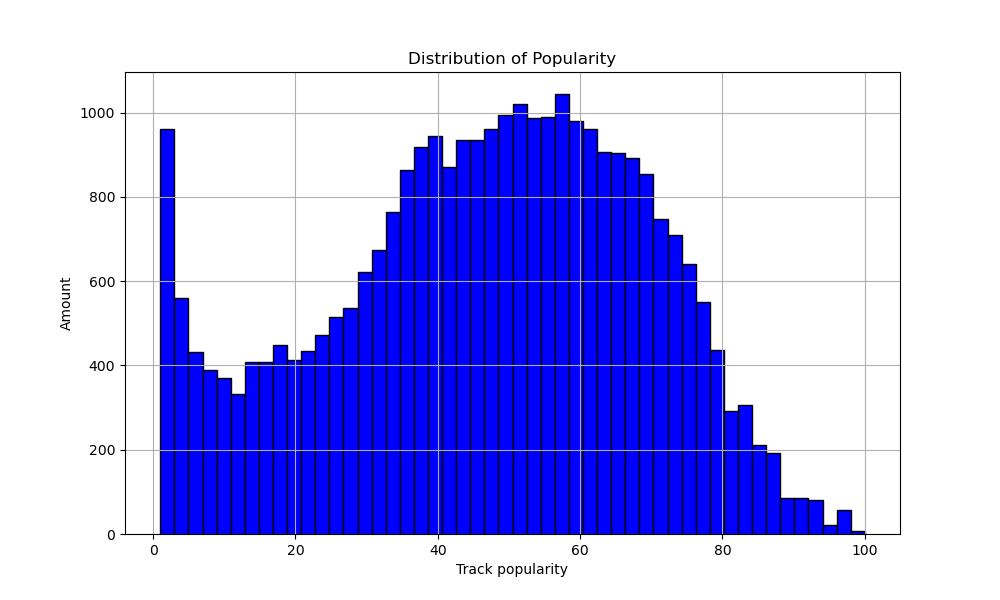

In [515]:
# Plot the distribution of track_popularity
plt.figure(figsize=(10,6))
plt.hist(df['track_popularity'], bins=50, color='blue', edgecolor='black')
plt.title('Distribution of Popularity')
plt.xlabel('Track popularity')
plt.ylabel('Amount')
plt.grid(True)
plt.show()

In [516]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30130 entries, 0 to 32832
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_artist              30130 non-null  object 
 1   track_popularity          30130 non-null  int64  
 2   track_album_release_date  30130 non-null  object 
 3   playlist_genre            30130 non-null  object 
 4   playlist_subgenre         30130 non-null  object 
 5   danceability              30130 non-null  float64
 6   energy                    30130 non-null  float64
 7   key                       30130 non-null  int64  
 8   loudness                  30130 non-null  float64
 9   mode                      30130 non-null  int64  
 10  speechiness               30130 non-null  float64
 11  acousticness              30130 non-null  float64
 12  instrumentalness          30130 non-null  float64
 13  liveness                  30130 non-null  float64
 14  valence    

## Divide track_popularity in classes(labels)

In [517]:
# Define the bin edges and labels
bin_edges = [0, 20, 40, 60, 80, 100]
bin_labels = [0, 1, 2, 3, 4]# ['Trash', 'Flop', 'Average', 'Hit', 'Monsterhit']

# Create a new column 'popularity_label' based on the bins
df['track_popularity'] = pd.cut(df['track_popularity'], bins=bin_edges, labels=bin_labels, include_lowest=True)
df['track_popularity_label'] = df['track_popularity'].astype(int)

In [518]:
df = df.drop(['track_popularity'],axis=1)

## Change release date to release year + scale duration to seconds

In [519]:
# make df['release_year'] a new column that stores the first 4 characters of df['track_album_release_date'] which is of Object type
#df['release_year'] = df['track_album_release_date'].astype(str).str[0:4].astype(int)

In [520]:
# Release date to years
df['track_album_release_date'] = pd.to_datetime(df['track_album_release_date'], errors='coerce')
df['release_year'] = (df['track_album_release_date'].dt.year)



df = df.drop(['track_album_release_date'], axis=1)

In [521]:
# Drop rows with missing values
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28466 entries, 0 to 32832
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   track_artist            28466 non-null  object 
 1   playlist_genre          28466 non-null  object 
 2   playlist_subgenre       28466 non-null  object 
 3   danceability            28466 non-null  float64
 4   energy                  28466 non-null  float64
 5   key                     28466 non-null  int64  
 6   loudness                28466 non-null  float64
 7   mode                    28466 non-null  int64  
 8   speechiness             28466 non-null  float64
 9   acousticness            28466 non-null  float64
 10  instrumentalness        28466 non-null  float64
 11  liveness                28466 non-null  float64
 12  valence                 28466 non-null  float64
 13  tempo                   28466 non-null  float64
 14  duration_ms             28466 non-null  int

In [522]:
# Track duration from ms to s
df['duration_ms'] = df['duration_ms']/1000

In [523]:
df = df.rename(columns={'duration_ms': 'duration_s'})

In [524]:
df.head()

,track_artist,playlist_genre,playlist_subgenre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_s,track_popularity_label,release_year
0,Ed Sheeran,pop,dance pop,0.748,0.916,6,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194.754,3,2019.0
1,Maroon 5,pop,dance pop,0.726,0.815,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162.600,3,2019.0
2,Zara Larsson,pop,dance pop,0.675,0.931,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176.616,3,2019.0
3,The Chainsmokers,pop,dance pop,0.718,0.930,7,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169.093,2,2019.0
4,Lewis Capaldi,pop,dance pop,0.650,0.833,1,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189.052,3,2019.0


In [525]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28466 entries, 0 to 32832
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   track_artist            28466 non-null  object 
 1   playlist_genre          28466 non-null  object 
 2   playlist_subgenre       28466 non-null  object 
 3   danceability            28466 non-null  float64
 4   energy                  28466 non-null  float64
 5   key                     28466 non-null  int64  
 6   loudness                28466 non-null  float64
 7   mode                    28466 non-null  int64  
 8   speechiness             28466 non-null  float64
 9   acousticness            28466 non-null  float64
 10  instrumentalness        28466 non-null  float64
 11  liveness                28466 non-null  float64
 12  valence                 28466 non-null  float64
 13  tempo                   28466 non-null  float64
 14  duration_s              28466 non-null  flo

## Making the model

### Dataset

In [612]:
X, y = df.drop(['track_popularity_label', 'track_artist', 'playlist_genre', 'playlist_subgenre'],axis=1).to_numpy(), df['track_popularity_label'].to_numpy()

In [613]:
print ('The shape of X is: ' + str(X.shape))
print ('The shape of y is: ' + str(y.shape))

The shape of X is: (28466, 13)
The shape of y is: (28466,)


In [614]:
# UNQ_C2
# GRADED CELL: Sequential model
tf.random.set_seed(1234) # for consistent results
model = Sequential(
    [
        ### START CODE HERE ###

        tf.keras.Input(shape=(13,)),    #specify input shape
        Dense(15, activation="relu", name="L1"),
        Dense(10, activation="relu", name="L2"),
        Dense(5, activation="linear", name="L3"),
        
        ### END CODE HERE ###
    ], name = "my_model"
)
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [615]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 L1 (Dense)                  (None, 15)                210       
                                                                 
 L2 (Dense)                  (None, 10)                160       
                                                                 
 L3 (Dense)                  (None, 5)                 55        
                                                                 
Total params: 425 (1.66 KB)
Trainable params: 425 (1.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [616]:
[layer1, layer2, layer3] = model.layers

In [617]:
#### Examine Weights shapes
W1,b1 = layer1.get_weights()
W2,b2 = layer2.get_weights()
W3,b3 = layer3.get_weights()
print(f"W1 shape = {W1.shape}, b1 shape = {b1.shape}")
print(f"W2 shape = {W2.shape}, b2 shape = {b2.shape}")
print(f"W3 shape = {W3.shape}, b3 shape = {b3.shape}")

W1 shape = (13, 15), b1 shape = (15,)
W2 shape = (15, 10), b2 shape = (10,)
W3 shape = (10, 5), b3 shape = (5,)


In [618]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
)

history = model.fit(
    X,y,
    epochs=40
)

Epoch 1/40
890/890 [==============================] - 2s 1ms/step - loss: 17.9077
Epoch 2/40
890/890 [==============================] - 2s 2ms/step - loss: 1.6722
Epoch 3/40
890/890 [==============================] - 1s 1ms/step - loss: 1.6165
Epoch 4/40
890/890 [==============================] - 1s 1ms/step - loss: 1.6227
Epoch 5/40
890/890 [==============================] - 1s 1ms/step - loss: 1.5967
Epoch 6/40
890/890 [==============================] - 1s 1ms/step - loss: 1.6013
Epoch 7/40
890/890 [==============================] - 1s 1ms/step - loss: 1.6104
Epoch 8/40
890/890 [==============================] - 1s 1ms/step - loss: 1.6084
Epoch 9/40
890/890 [==============================] - 1s 1ms/step - loss: 1.5883
Epoch 10/40
890/890 [==============================] - 1s 2ms/step - loss: 1.5906
Epoch 11/40
890/890 [==============================] - 2s 2ms/step - loss: 1.5872
Epoch 12/40
890/890 [==============================] - 2s 2ms/step - loss: 1.5708
Epoch 13/40
890/890 [===

In [638]:
df.head()
#give df value at row 23
df.iloc[2]
#give me the row with the highest track_popularity_label         
df.loc[df['track_popularity_label'].idxmax()]

track_artist                    Kygo
playlist_genre                   pop
playlist_subgenre          dance pop
danceability                   0.693
energy                         0.678
key                                8
loudness                      -7.159
mode                               1
speechiness                   0.0324
acousticness                  0.0154
instrumentalness            0.000006
liveness                       0.101
valence                        0.404
tempo                     103.952003
duration_s                228.266998
track_popularity_label             4
release_year                    2019
Name: 41, dtype: object

In [645]:
Ed_IHE_Remix = X[41]
print(Ed_IHE_Remix.shape)
prediction = model.predict(Ed_IHE_Remix.reshape(1,13))
print(f" predicting a Two: \n{prediction}")
print(f" Largest Prediction index: {np.argmax(prediction)}")

(13,)
1/1 [==============================] - 0s 42ms/step
 predicting a Two: 
[[2.6558795  3.093584   3.4383073  2.941347   0.96539915]]
 Largest Prediction index: 2


In [646]:
prediction_p = tf.nn.softmax(prediction)

print(f" predicting a Two. Probability vector: \n{prediction_p}")
yhat = np.argmax(prediction_p)

print(f"np.argmax(prediction_p): {yhat}")

 predicting a Two. Probability vector: 
[[0.15998116 0.24783435 0.34984276 0.21283633 0.02950547]]
np.argmax(prediction_p): 2
